# Machine Learning Interpretability with Shapley values
## Waterfall plot for DeepExplainer

This notebook assumes an understanding of fitting a keras neural network and using the SHAP library.

For a more introductory notebook for fitting a keras neural network see: https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/20a_tensorflow_simple.ipynb

For a more introductory notebook for the SHAP library see:
https://github.com/MichaelAllen1966/shapley

This notebook is in three parts, with the main focus being on the third part: 
1. The first part of this notebook reads titanic data and fits a keras neural network.
2. The second part uses the SHAP library to calculate the shapley values for each feature of this model.
3. The third and final part contains and uses a function that creates a waterfall plot of the shapley values for each feature of the model, for a single feature. The waterfall functionality exists in the SHAP library for Explainers for other model types (for example logistic regression), but not for the DeepExplainer that is used for Keras models.

## First set up Google Colab

First ensure you have selected GPU from 'runtime' / 'change runtime type'. This may require you then to restart the runtime.

Then run the code below to change TensorFlow version to 2.2.0. 

AFTER RUNNING THIS CELL PLEASE RESTART THE RUNTIME.

In [1]:
# Select 'GPU' from 'runtime' / 'change runtime type'

downgrade_tensorflow = True

import tensorflow
print(tensorflow.__version__)

if downgrade_tensorflow and tensorflow.__version__ != '2.2.0':
    !pip uninstall tensorflow
    !pip install tensorflow==2.2.0
    import tensorflow
    print(tensorflow.__version__)

2.2.0


## Import libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# sklearn for pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

# TensorFlow sequential model
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

# Install shap if necessary (e.g. running in Google Colab)
try:
    import shap
except:
    !pip install shap
    import shap

## Part 1. Read titanic data and fits a keras neural network.

## Classification: Titanic Survival

Here we load upa data set giving feature values for passengers on the Titanic, and whether they survived or not.

In [3]:
# Data will be loaded from web if not available locally (for Google Colab)
try:
    data = pd.read_csv('data/titanic.csv')
except:
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

# Make all data 'float' type
data = data.astype(float)
# Drop passenger ID
data.drop(['PassengerId'], axis=1, inplace=True)

In [4]:
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,AgeImputed,EmbarkedImputed,CabinLetterImputed,CabinNumber,...,Embarked_missing,CabinLetter_A,CabinLetter_B,CabinLetter_C,CabinLetter_D,CabinLetter_E,CabinLetter_F,CabinLetter_G,CabinLetter_T,CabinLetter_missing
0,0.0,3.0,22.0,1.0,0.0,7.2500,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,38.0,1.0,0.0,71.2833,0.0,0.0,0.0,85.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,0.0,123.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3.0,35.0,0.0,0.0,8.0500,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Split X, and y, and split into training and test sets.

In [5]:
X = data.drop(['Survived'],axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

Define a function to standardise the data using SciKit Learn's `MinMaxScaler`.

In [7]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc

In [8]:
X_train_sc, X_test_sc = scale_data(X_train, X_test)

In [9]:
def make_net(number_features, learning_rate=0.003):
    
    # Clear Tensorflow 
    K.clear_session()
    
    # Set up neural net
    net = Sequential()
    net.add(Dense(240, input_dim=number_features, activation='relu'))
    net.add(Dropout(0.2))
    net.add(Dense(50, input_dim=number_features, activation='relu'))
    net.add(Dense(1, activation='sigmoid'))    
    
    # Compiling model
    opt = Adam(lr=learning_rate)
    
    net.compile(loss='binary_crossentropy', 
                optimizer=opt, 
                metrics=['accuracy'])
    
    return net

In [10]:
# Define network
number_features = X_train_sc.shape[1]
model = make_net(number_features)
    
### Train model
model.fit(X_train_sc,
         y_train,
         epochs=150,
         batch_size=32,
         verbose=0)

## Part 2. Uses the SHAP library to calculate the shapley values for each feature of this model

## Shapley values

In [11]:
explainer = shap.DeepExplainer(model, X_train_sc)

In [12]:
[z for z in dir(explainer) if z[0:2] != '__']

['_compute_main_effects',
 '_instantiated_load',
 'expected_value',
 'explain_row',
 'explainer',
 'load',
 'save',
 'shap_values',
 'supports_model_with_masker']

Get Shapley values. Note that the Shapley values can only be retrieved by themselves.

In [13]:
shap_values = explainer.shap_values(X_train_sc)

In [14]:
# Shap values for a single instance
shap_values[0][0]

array([-7.20057465e-03, -6.62902350e-02,  5.26521542e-02,  1.16872888e-02,
        9.22289414e-02, -3.87852496e-03, -8.49153936e-05, -3.12066536e-02,
        2.94597154e-01,  9.95096509e-02, -1.65018553e-01,  6.89131231e-02,
        5.07751341e-03, -1.89172226e-02, -9.10791318e-05, -5.90192943e-03,
       -3.84886556e-03, -2.43815354e-02, -1.36690009e-02, -4.88517269e-03,
        6.83562802e-04,  2.05135827e-03,  4.38673991e-04,  6.01081140e-03])

## Show global influence of features.

In [15]:
# Convert back to DataFrame to add feature names to chart
X_train_sc_df = pd.DataFrame(X_train_sc, columns=list(X_train))
X_test_sc_df = pd.DataFrame(X_test_sc, columns=list(X_train))

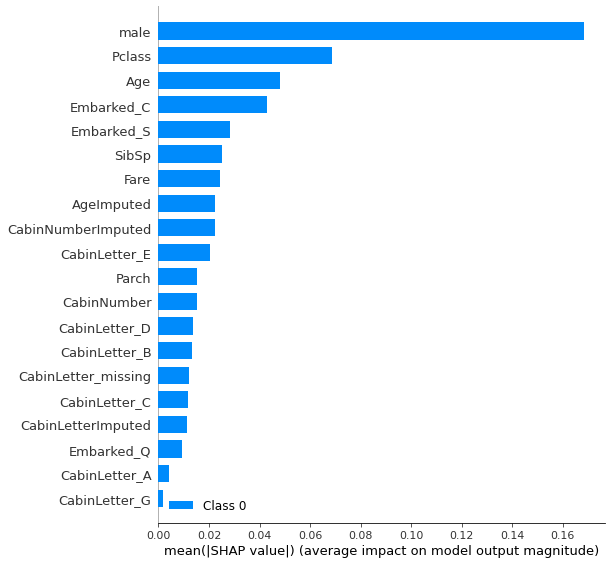

In [16]:
shap.summary_plot(shap_values, X_train_sc_df, plot_type='bar')

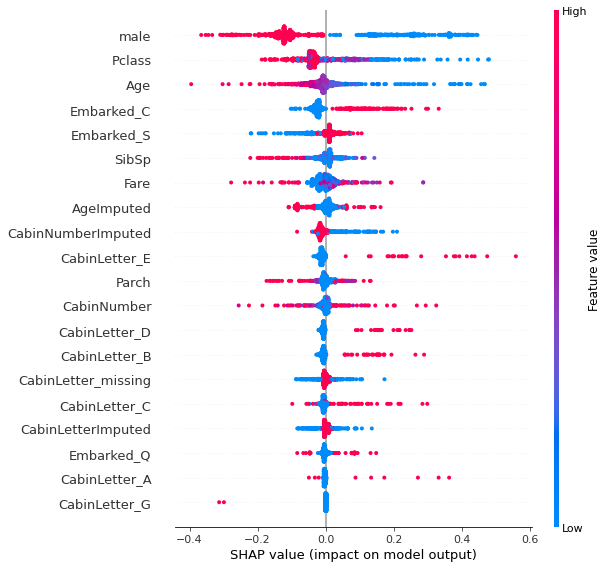

In [17]:
shap.summary_plot(shap_values[0], X_train_sc_df)

## Influence of features in individual examples in the test set

Here we will look at individial instance predictions, and how the different features contributed to prediction for that instance.

Let's examine the first test set instance:

In [18]:
X_test.iloc[0]

Pclass                  3.0000
Age                    28.0000
SibSp                   1.0000
Parch                   0.0000
Fare                   14.4542
AgeImputed              1.0000
EmbarkedImputed         0.0000
CabinLetterImputed      1.0000
CabinNumber             0.0000
CabinNumberImputed      1.0000
male                    0.0000
Embarked_C              1.0000
Embarked_Q              0.0000
Embarked_S              0.0000
Embarked_missing        0.0000
CabinLetter_A           0.0000
CabinLetter_B           0.0000
CabinLetter_C           0.0000
CabinLetter_D           0.0000
CabinLetter_E           0.0000
CabinLetter_F           0.0000
CabinLetter_G           0.0000
CabinLetter_T           0.0000
CabinLetter_missing     1.0000
Name: 240, dtype: float64

In [19]:
background = X_train_sc[np.random.choice(X_train_sc.shape[0], 100, replace=False)]
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(X_test_sc)

In [20]:
# Shap values for first instance
shap_values[0][0]

array([-4.98963075e-02,  2.31270705e-03,  4.70456954e-02,  2.71976004e-02,
        1.34110130e-02,  1.37344434e-01,  0.00000000e+00,  5.07423873e-03,
       -5.81628489e-04, -7.91222160e-03,  2.81274484e-01,  1.12438384e-01,
       -7.35244513e-03,  1.84872144e-02,  0.00000000e+00, -1.38930362e-04,
       -2.70678456e-03,  7.02596600e-04, -8.12192159e-03, -1.18252486e-04,
       -4.66842693e-05,  0.00000000e+00,  0.00000000e+00,  6.50872961e-03])

In [21]:
# Calculate Shap values
instance = 0
chosen_instance = X_test.iloc[instance]
shap_values_instance = shap_values[0][instance]
expected_value = np.repeat(explainer.expected_value, len(shap_values))
shap.initjs()
shap.force_plot(expected_value, shap_values_instance, chosen_instance)

## Part 3. A function that creates a waterfall plot of the shapley values for each feature of the model, for a single instance

## Code to create waterfall plot for shapley values as calculated by DeepExplainer (from the SHAP library)

We will use the data as calculated in the previous code cell. This is data for a single instance:

1) chosen_instance = X_test.iloc[instance]
2) shap_values_instance = shap_values[0][instance]
3) explainer.expected_value

In addition to the variables set up above (choosen_instance, shap_values_instance, expected_value), we also want the predicted output value from the model. Use this to compare with the culmulative sum of the shapley value.

In [22]:
predict = model.predict(X_test_sc)
chosen_predict = predict[instance]

Import libraries

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

Function to create waterfall plot

In [24]:
def waterfall_plot(chosen_instance, shap_values_instance, expected_value, 
                   predicted_value, max_display=-1, style_arrows=False):
    """
    chosen_instance: [pandas dataframe] the index is feature name, value is 
                     feature value for instance
    shap_values_instance: [numpy array] the shapley values for each feature for 
                          the instance
    expected_value: [float] the output value that is expected for the dataset 
                    (e.g. median)
    predicted_value: [float] the predicted output for the instance
    max_display: [integer] the number of features to include in the waterfall
                  plot. If nothing is passed, all features are plotted
    style_arrows: [boolean] whether to display as a horizontal bar chart 
                  (False), or using arrows (True)
    
    """
    
    # set up pandas dataframe with the data required for the waterfall chart
    data = pd.DataFrame(chosen_instance)
    data.columns = ["instance"]
    data["shap"] = shap_values_instance
    data["shap_absolute"] = np.abs(shap_values_instance)
    
    # limit the number of features to display to the number available
    max_display = min(max_display, data.shape[0])

    # if max_display not passed, set to total number of features available
    if max_display == -1:
        max_display = data.shape[0]
        
    # sort the rows on the absolute shapley values (smallest value at top)
    data = data.sort_values(by=["shap_absolute"], 
                                      ascending=True)

    # if want to display fewer features than the full set
    if max_display < data.shape[0]:

        # select features ranked by most influence
        waterfall_plot = data.tail(max_display)    

        # represent the remaining features as one row
        waterfall_plot_remaining = data.iloc[0:-max_display]
        summary_remaining = pd.DataFrame(
                                    columns=waterfall_plot_remaining.columns)
        summary_remaining["instance"] = [np.nan]
        summary_remaining["shap"] = [waterfall_plot_remaining.shap.sum()]
        summary_remaining["shap_absolute"] = (
                                [np.abs(waterfall_plot_remaining.shap.sum())])
        index_title = f"remaining_{waterfall_plot_remaining.shape[0]}_features"
        summary_remaining.index = [index_title]
        waterfall_plot = summary_remaining.append(waterfall_plot)

    else:
        waterfall_plot = data.copy(deep=True)
        
    # create two new columns containing the x coordinates for the lhs and rhs of
    # each bar    
    # one side of the first bar is the expected value plus the bar's shapley 
    # value. The remaining bars take as one side the culmulative sum of the
    # shapley values and the expected value.
    shap_series = waterfall_plot.shap.copy(deep=True)
    shap_series[0] = shap_series[0] + explainer.expected_value
    shap_cumsum = shap_series.cumsum()

    # the other side of each bar is the value from the previous bar (for the 
    # first bar, this is the expected value)
    shap_cumsum_prev = shap_cumsum.copy(deep=True)
    shap_cumsum_prev[1:] = shap_cumsum_prev[0:-1]
    shap_cumsum_prev[0] = explainer.expected_value

    # the shapley values can be either sign, so the LHS is the min of both
    # series, and the RHS is the max of both series
    # add these to the waterfall_plot DataFrame
    lhs_bar = pd.DataFrame([shap_cumsum_prev, shap_cumsum]).min()
    rhs_bar = pd.DataFrame([shap_cumsum_prev, shap_cumsum]).max()
    waterfall_plot["lhs_bar"] = lhs_bar
    waterfall_plot["rhs_bar"] = rhs_bar
        
    # add the expected and predicted value for this instance to the DataFrame
    model_predict = shap_cumsum[-1]
    abs_diff = np.abs(model_predict-predicted_value)
    if abs_diff > 0.000001:
        print(f"There is a difference between the predicted value from the model"
              f" and the culmulative sum of the shapley values: {abs_diff}")

    model_predict = np.repeat(model_predict, waterfall_plot.shape[0])
    waterfall_plot["model_predict"] = model_predict    
    exp_value = np.repeat(explainer.expected_value, waterfall_plot.shape[0])
    waterfall_plot["expected_value"] = exp_value
        
    # the plot will show blue for positive shapley value, and red for negative
    c = waterfall_plot.shap.copy(deep = True)
    mask_lt = c < 0
    mask_gt = c >= 0
    c[mask_lt] = "r"
    c[mask_gt] = "b"
    waterfall_plot["bar_colour"] = c
    
    # set up other parameters for the waterfall plot:
    # number of features
    n_features = waterfall_plot.shape[0]
    # positions for the y axis items
    pos = np.arange(0.5, n_features * 0.5 + 0.5, 0.5)
    # labels for the y axis (feature name and feature value)
    labels = waterfall_plot.index.astype(str) + " (" + waterfall_plot.instance.astype(str) + ")"
    
    ### ### ### create the plot ### ### ###
    
    # set size of plot (width is constant, height is based on number of features)
    fig = plt.figure(figsize=(20, 0.4 * (max_display + 1)))
    ax1 = fig.add_subplot(111)

    # for each feature of the model create a horizontal bar
    for i in range(n_features):
        
        # get the position for the bar
        lhs_bar = waterfall_plot.lhs_bar.iloc[i]
        rhs_bar = waterfall_plot.rhs_bar.iloc[i]

        # allocate colour (based on sign of shapley value)
        colour = waterfall_plot.bar_colour.iloc[i]

        if style_arrows:
            # create plot with arrows
            
            # direction of the arrow depends on the sign of the shapley value
            if waterfall_plot.shap.iloc[i] < 0:
                x_tail = rhs_bar
                x_head = lhs_bar
            else:
                x_tail = lhs_bar
                x_head = rhs_bar

            # height of arrow the same regardless of sign of shapley value
            y_tail = (i * 0.5) + 0.5
            y_head = (i * 0.5) + 0.5
            
            # create arrow
            arrow = mpatches.FancyArrowPatch((x_tail, y_tail), 
                                             (x_head, y_head),
                                              mutation_scale=10,
                                              color = colour,
                                              ec = colour)
            # plot arrow
            ax1.add_patch(arrow)

        else: 
            # create plot with bars
            ax1.barh((i * 0.5) + 0.5, 
                     rhs_bar - lhs_bar, 
                     left = lhs_bar, 
                     height = 0.3, 
                     align = 'center', 
                     edgecolor = colour, 
                     color = colour, 
                     alpha = 0.8)


        # add text (the shapley value) to each bar
        # location depends on sign of shapley value
        if waterfall_plot.shap.iloc[i] < 0:
            text_xaxis = lhs_bar - 0.02
        else:
            text_xaxis = rhs_bar + 0.005
        text_yaxis = (i * 0.5) + 0.4

        ax1.text(text_xaxis, 
                 text_yaxis,
                 str(round(waterfall_plot.shap.iloc[i], 2)), 
                 fontsize=8,
                 color=colour)

    # expand xlim and ylim to make labels easier to read
    ax1.set_ylim(0,np.max(pos)*1.02)
    x_left, x_right = ax1.get_xlim()
    ax1.set_xlim(x_left*0.8, x_right*1.2) 
    x_left, x_right = ax1.get_xlim()
    
    #convert values into axis units so the arrow points to the right place
    expected_value_xaxis = ((waterfall_plot.expected_value[0] -x_left) / 
                            (x_right - x_left))
    model_predict_xaxis = ((waterfall_plot.model_predict[0] -x_left) / 
                           (x_right - x_left))

    # set properties for the arrow
    arrow_args = dict(arrowstyle="->")

    # annotate the expected value on the bottom of the x axis
    ax1.annotate(f'E[f(x)] = {waterfall_plot.expected_value[0]}', 
                 xy=(expected_value_xaxis, 0), 
                 xycoords='axes fraction',
                 xytext=(-70, -40), 
                 textcoords='offset points',
                 ha="left", va="bottom",
                 arrowprops=arrow_args)

    # annotate the predicted value on the top of the x axis
    ax1.annotate(f'f(x)= {waterfall_plot.model_predict[0]}', 
                 xy=(model_predict_xaxis, 1), 
                 xycoords='axes fraction',
                 xytext=(-80, 20), 
                 textcoords='offset points',
                 ha="left", va="bottom",
                 arrowprops=arrow_args)

    ax1.set_yticks(pos)
    ax1.set_yticklabels(labels)
    ax1.set_title('Shapley values for each feature for a single instance')

    plt.show()    

### Example 1: using the waterfall function, passing the four mandatory arguments

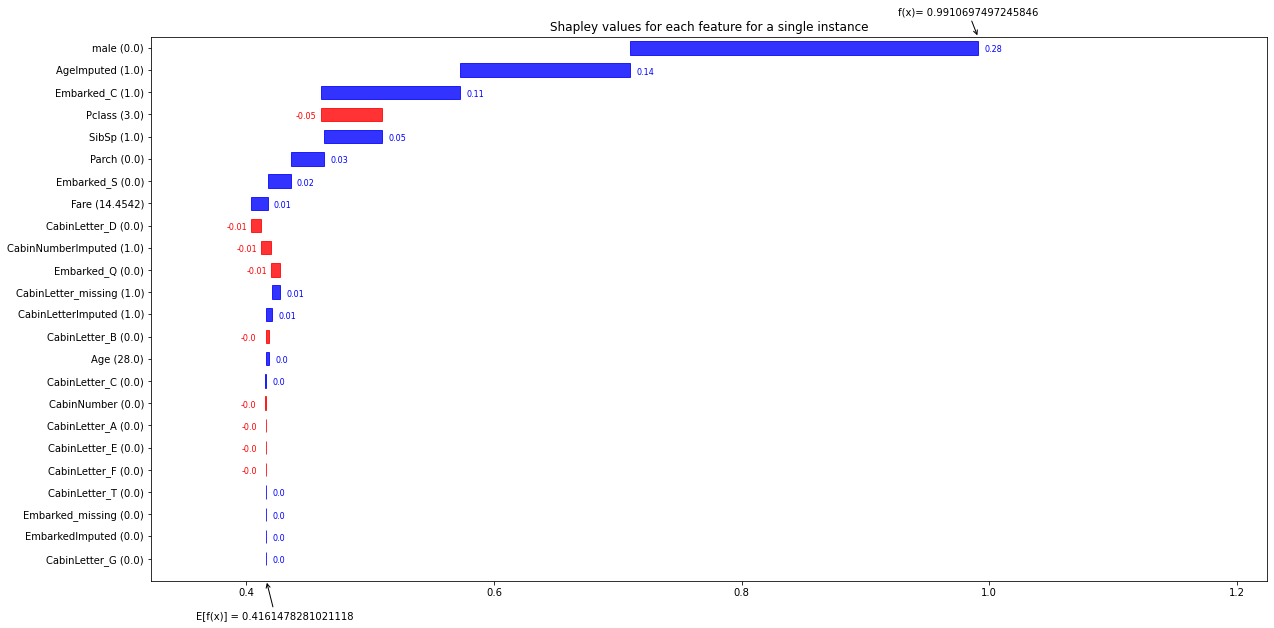

In [25]:
waterfall_plot(chosen_instance, 
               shap_values_instance, 
               expected_value,
               chosen_predict)

### Example 2: using the waterfall function, passing the four mandatory arguments and one optional argument (max_display)

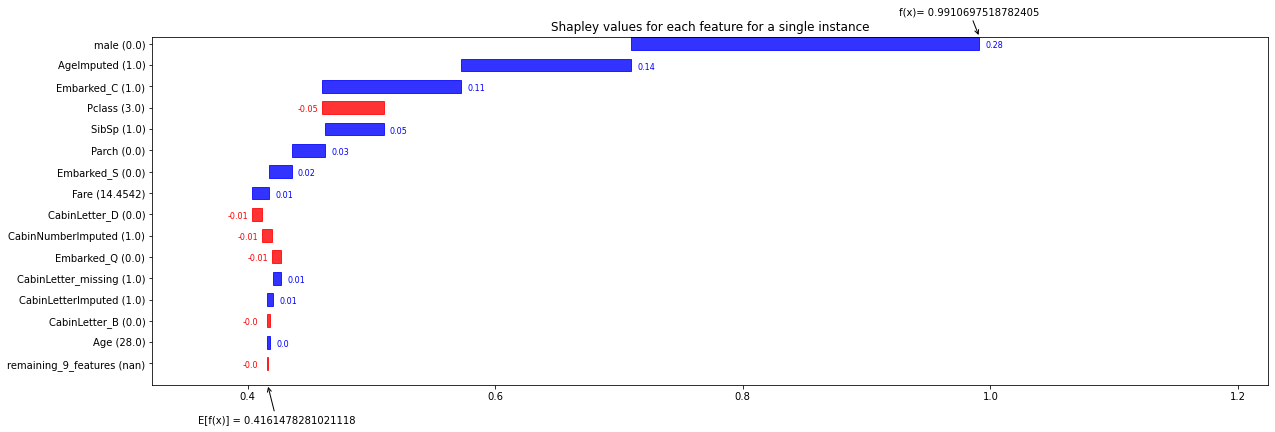

In [26]:
waterfall_plot(chosen_instance, 
               shap_values_instance, 
               expected_value,
               chosen_predict, 
               max_display=15)

### Example 3: using the waterfall function, passing the four mandatory arguments and both optional arguments (max_display and style_arrows)

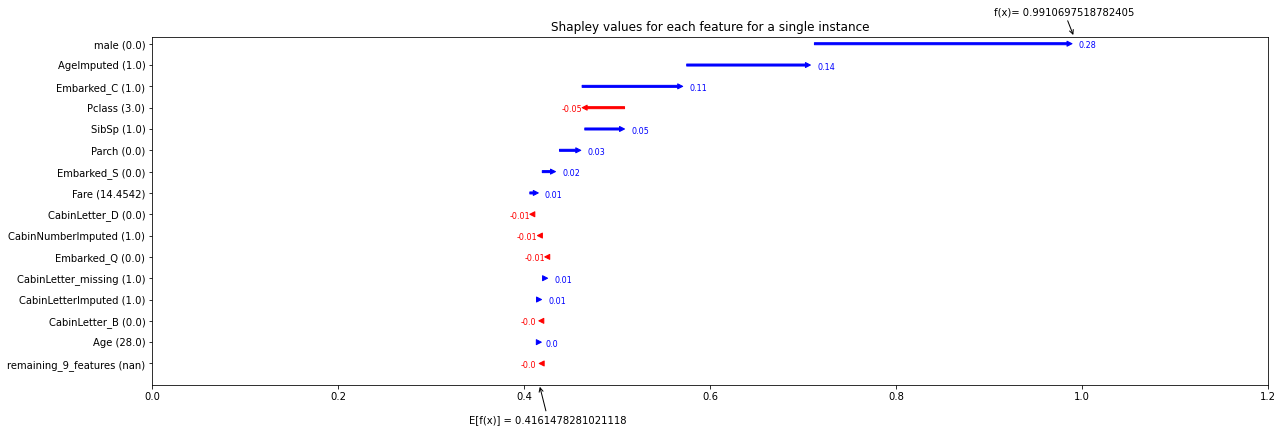

In [27]:
waterfall_plot(chosen_instance, 
               shap_values_instance, 
               expected_value,
               chosen_predict, 
               max_display=15,
               style_arrows=True)